In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit

In [2]:
pauli_list = [
    np.eye(2),
    np.array([[0.0, 1.0], [1.0, 0.0]]),
    np.array([[0, -1.0j], [1.0j, 0.0]]),
    np.array([[1.0, 0.0], [0.0, -1.0]]),
]
s_to_pauli = {
    "I": pauli_list[0],
    "X": pauli_list[1],
    "Y": pauli_list[2],
    "Z": pauli_list[3],
}

# Ancilla Based ShadowQPT

<div>
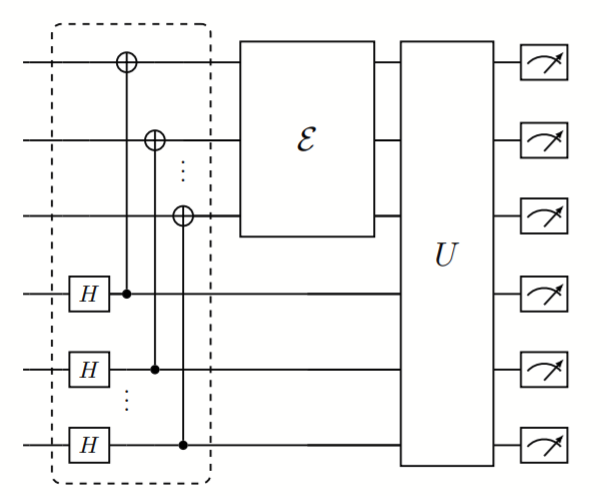
</div>


We'll now use the gates to create the n-qubit GHZ state (i.e. the GHZ process) as our process to perform quantum process tomography using classical shadows. Our target is the Choi matrix $\Lambda$

In [3]:
def channel(N,qc):
    '''create an N qubit GHZ state '''
    qc.h(0)
    if N>=2: qc.cx(0,1)
    if N>=3: qc.cx(0,2)
    if N>=4: qc.cx(1,3)
    if N>4: raise NotImplementedError(f"{N} not implemented!")

    
def bitGateMap(qc,g,qi):
    '''Map X/Y/Z string to qiskit ops'''
    if g=="X":
        qc.h(qi)
    elif g=="Y":
        qc.sdg(qi)
        qc.h(qi)
    elif g=="Z":
        pass
    else:
        raise NotImplementedError(f"Unknown gate {g}")
def Minv(N,X):
    '''inverse shadow channel'''
    return ((2**N+1.))*X - np.eye(2**N)

def trace_dist(lam_exact,rho):
    ''' returns normalized trace distance between lam_exact and rho'''
    mid = (lam_exact-rho).conj().T@(lam_exact-rho)
    N = 2**int(np.log2(lam_exact.shape[0])/2)
    # svd mid and apply sqrt to singular values
    # based on qiskit internals function
    U1,d,U2 = np.linalg.svd(mid)
    sqrt_mid = U1@np.diag(np.sqrt(d))@U2
    dist = np.trace(sqrt_mid)/2
    return dist/N

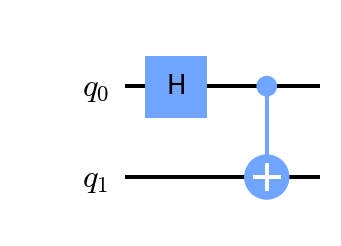

In [4]:
qc = qiskit.QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)

choi_actual = qiskit.quantum_info.Choi(qc)
qc.draw(output='mpl')

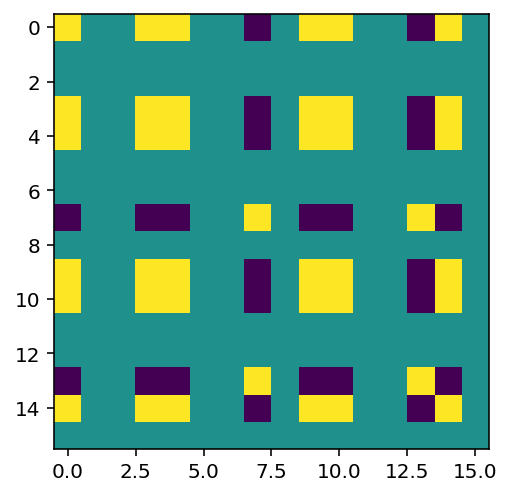

In [5]:
plt.imshow(choi_actual.data.real)

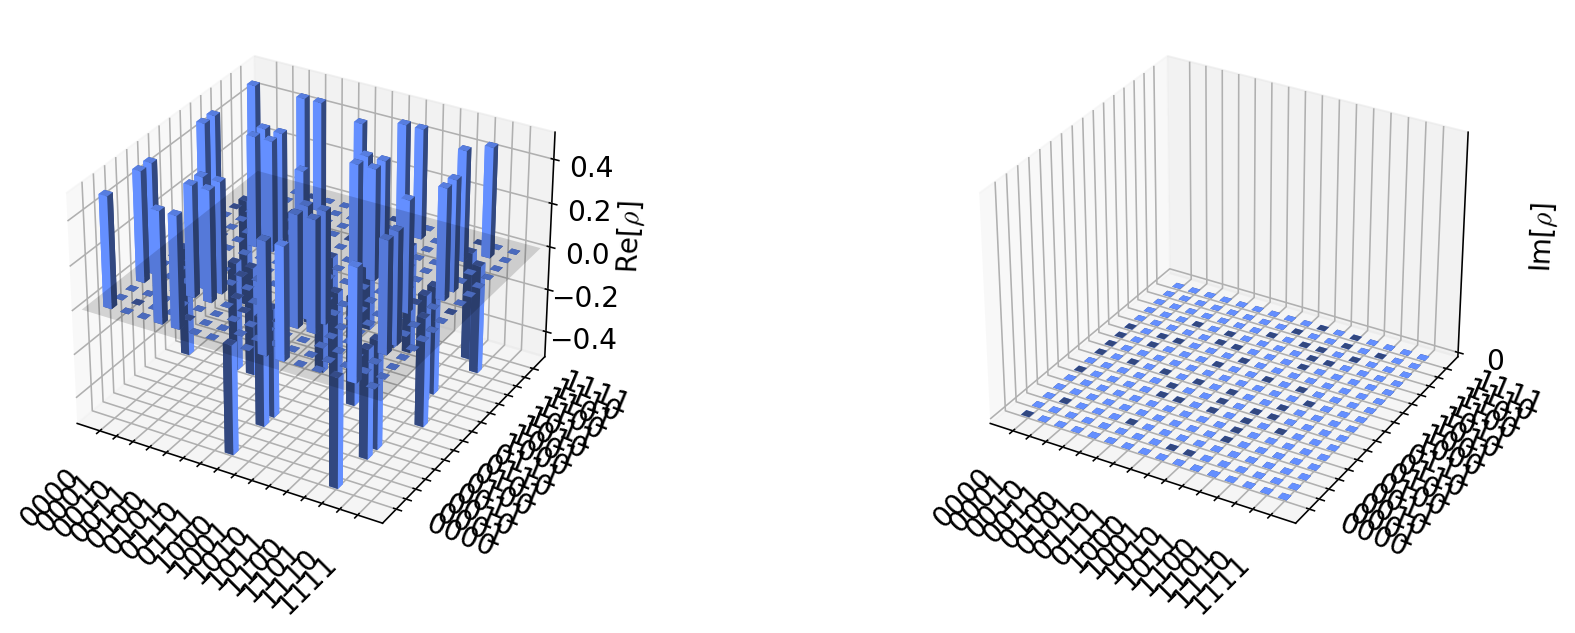

In [6]:
qiskit.visualization.state_visualization.plot_state_city(choi_actual.data)

Using ancillas, we can form a $n$-qubit channel 'problem' into a $2n$-qubit density matrix 'problem'

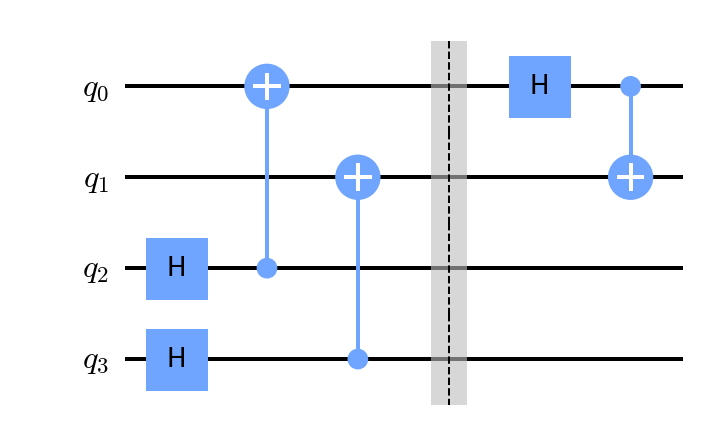

In [7]:
N = 2
qc = qiskit.QuantumCircuit(2*N)
for i in range(N):
    qc.h(i+N)
    qc.cx(i+N,i)
qc.barrier()
channel(N,qc)
qc.draw(output='mpl')

In [8]:
choi_state = qiskit.quantum_info.DensityMatrix(qc)
# this is the same up to normalization
# Tr[lambda] = 2^N
np.allclose(choi_state.data*2**N,choi_actual)

True

# Fixed $n$

## Clifford

In [9]:
nShadows = 1_000
reps = 50
N = 2
rng = np.random.default_rng(1717)
cliffords = [qiskit.quantum_info.random_clifford(N*2,seed=rng) for _ in range(nShadows)]

N = 2
qc = qiskit.QuantumCircuit(2*N)
for i in range(N):
    qc.h(i+N)
    qc.cx(i+N,i)
channel(N,qc)

results = []
for cliff in cliffords:
    qc_c  = qc.compose(cliff.to_circuit())

    counts = qiskit.quantum_info.Statevector(qc_c).sample_counts(reps)
    results.append(counts)

In [10]:
rho_shadow = 0.+0j
for cliff,res in zip(cliffords,results):
    mat    = cliff.adjoint().to_matrix()
    for bit,count in res.items():
        Ub = mat[:,int(bit,2)] # this is Udag|b>
        rho_shadow += (Minv(N*2,np.outer(Ub,Ub.conj()))*count)

rho_shadow /=( nShadows*reps)
rho_shadow *= 2**N

In [11]:
assert np.allclose(rho_shadow.trace(),2**N)

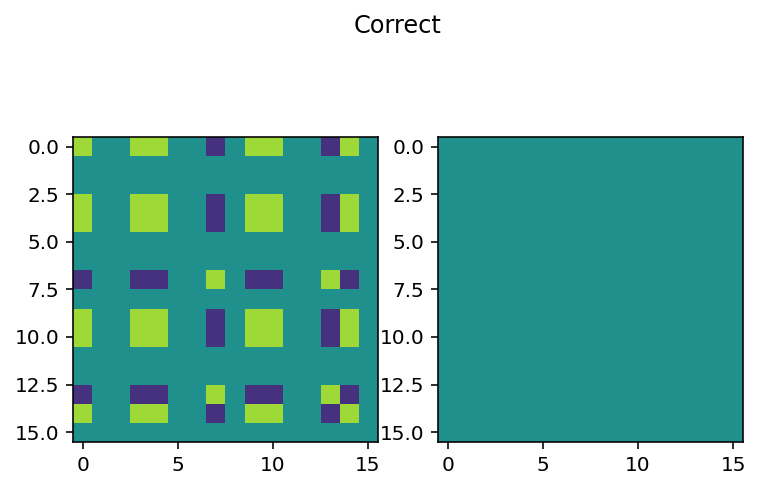

---


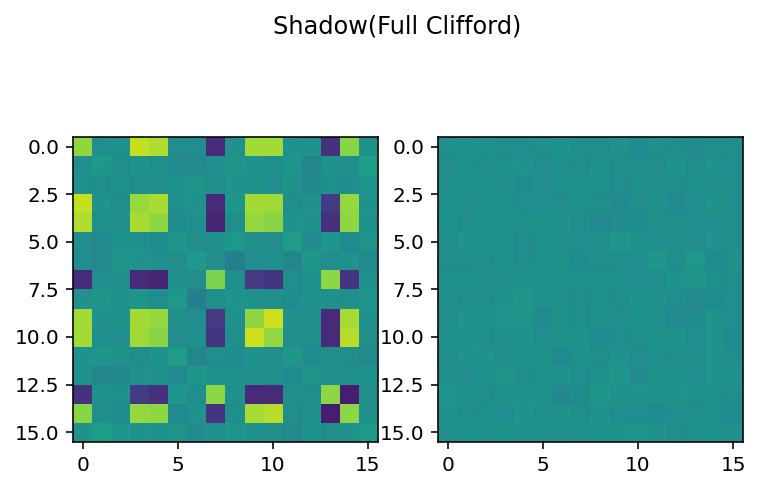

In [12]:


plt.subplot(121)
plt.suptitle("Correct")
plt.imshow(choi_actual.data.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)
plt.imshow(choi_actual.data.imag,vmax=0.7,vmin=-0.7)
plt.show()
print("---")

plt.subplot(121)
plt.suptitle("Shadow(Full Clifford)")
plt.imshow(rho_shadow.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)
plt.imshow(rho_shadow.imag,vmax=0.7,vmin=-0.7)
plt.show()

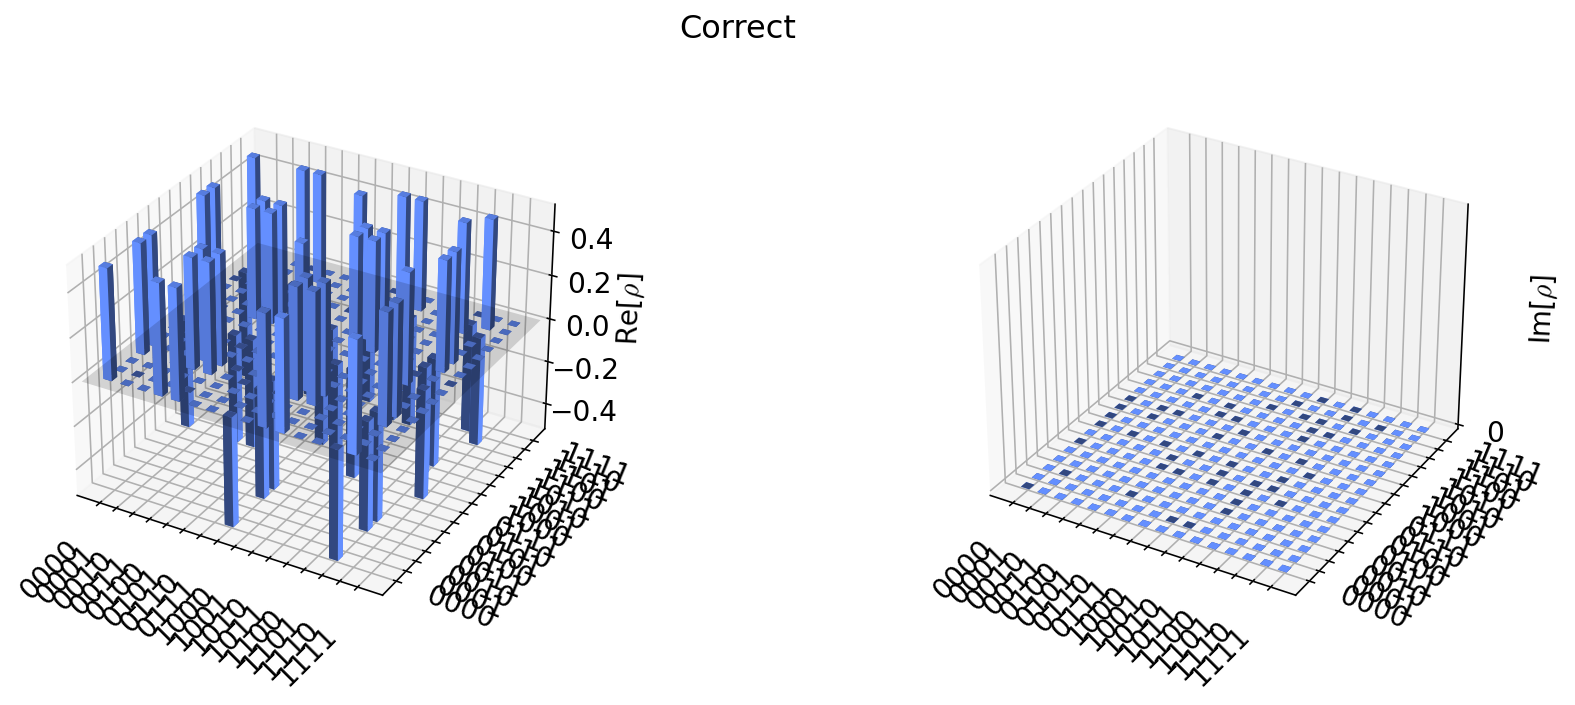

In [13]:
qiskit.visualization.state_visualization.plot_state_city(choi_actual.data,title="Correct")


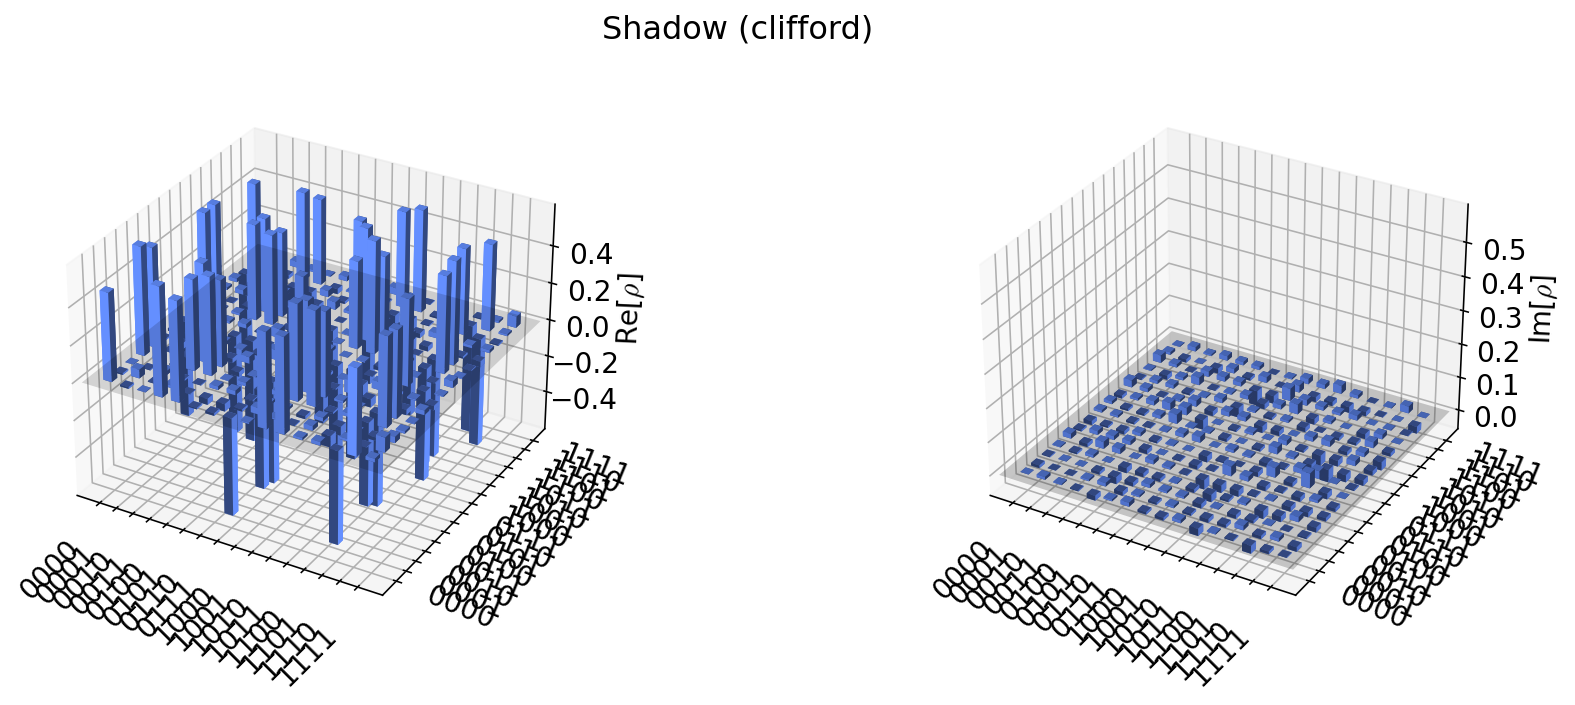

In [14]:
qiskit.visualization.state_visualization.plot_state_city(rho_shadow,title="Shadow (clifford)")


## Post Processing Steps

The shadow Choi matrix isn't very physical, so what can we do to fix that?
The easiest is purifying, which will project into the space of $\mathcal{CP}$ maps.   
For more advanced procedures, see [arxiv:1803.10062](https://arxiv.org/abs/1803.10062) (doi:10.1103/PhysRevA.98.062336)

In [15]:
_,vs = np.linalg.eigh(rho_shadow)
rho_shadow_pure = np.outer(vs[:,-1],vs[:,-1].conj().T)*2**N

In [16]:
print(f"original trace distance = {trace_dist(choi_actual.data,rho_shadow).real:0.4f}")
print(f"Purified  trace distance = {trace_dist(choi_actual.data,rho_shadow_pure).real:0.4f}")

original trace distance = 0.2220
Purified  trace distance = 0.0277


# Two Sided

Previously we saw we needed $2N$ qubits to perform ancilla-assisted QPT. Here, let's explore using a two-sided approach using classical shadows

<div>
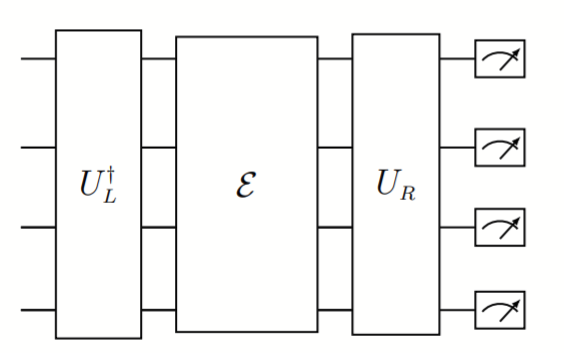
</div>


In [17]:
nShadows = 1_000
reps = 50
N = 2
rng = np.random.default_rng(1717)
front_cliffords = [qiskit.quantum_info.random_clifford(N,seed=rng) for _ in range(nShadows)]
back_cliffords  = [qiskit.quantum_info.random_clifford(N,seed=rng) for _ in range(nShadows)]


N = 2
qc = qiskit.QuantumCircuit(N)
results = []
for front,back in zip(front_cliffords,back_cliffords):
    qc_c = qc.compose(front.adjoint().to_circuit())
    channel(N,qc_c)
    qc_c = qc_c.compose(back.to_circuit())

    counts = qiskit.quantum_info.Statevector(qc_c).sample_counts(reps)
    results.append(counts)

In [18]:
rho_shadow2 = 0.+0j
for front, back, res in zip(front_cliffords, back_cliffords, results):
    mat_front = front.to_matrix()
    mat_back  = back.adjoint().to_matrix()

    U0_front = mat_front.T[:, 0]  # this is <0|U or U^T|0>
    M_front  = Minv(N, np.outer(U0_front, U0_front.conj()))
    for bit, count in res.items():
        Ub     = mat_back[:, int(bit, 2)]  # this is Udag|b>
        M_back = Minv(N, np.outer(Ub, Ub.conj()))
        rho_shadow2 += np.kron(M_front, M_back) * count
rho_shadow2 /= nShadows * reps
rho_shadow2 *= 2**N

In [19]:
assert np.allclose(rho_shadow2.trace(),2**N)

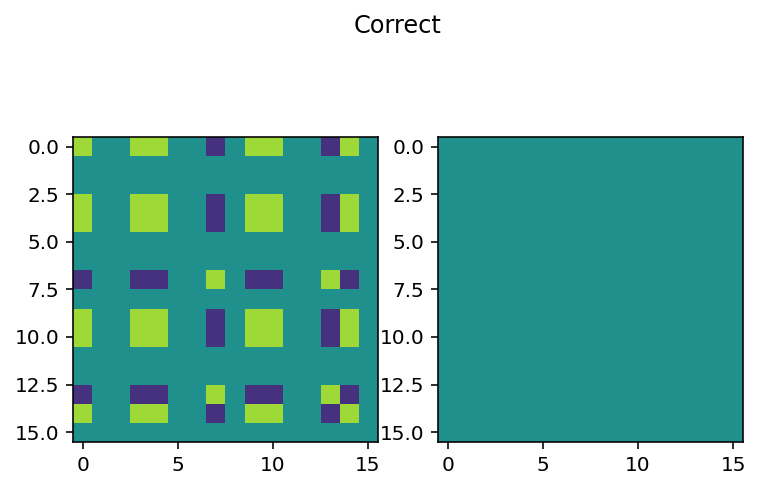

---


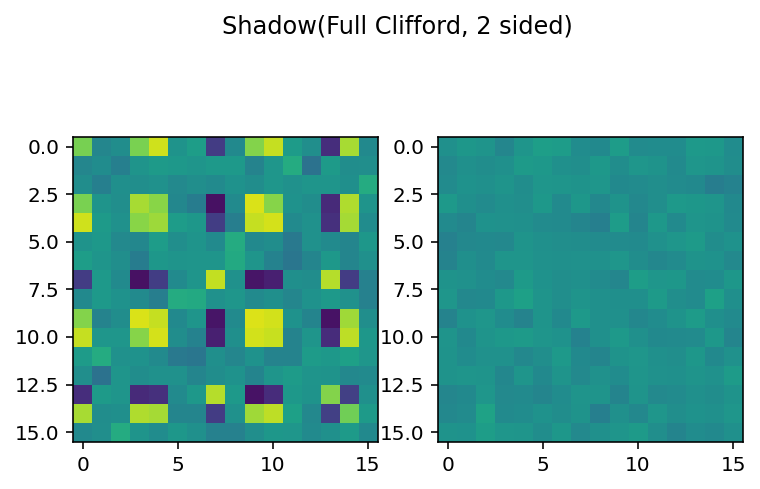

In [20]:


plt.subplot(121)
plt.suptitle("Correct")
plt.imshow(choi_actual.data.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)
plt.imshow(choi_actual.data.imag,vmax=0.7,vmin=-0.7)
plt.show()
print("---")

plt.subplot(121)
plt.suptitle("Shadow(Full Clifford, 2 sided)")
plt.imshow(rho_shadow2.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)
plt.imshow(rho_shadow2.imag,vmax=0.7,vmin=-0.7)
plt.show()

In [21]:
print(f"ancilla trace distance   = {trace_dist(choi_actual.data,rho_shadow).real:0.4f}")
print(f"two sided trace distance = {trace_dist(choi_actual.data,rho_shadow2).real:0.4f}")

ancilla trace distance   = 0.2220
two sided trace distance = 0.5064


Above you can see that, if we have access to larger 2n-qubit Clifford circuits*, the ancilla method will obtain better results under a "shots" like method

<small style='font-size: 10px;'>*along with all the other computational difficulty with implementing the ancilla version </small>

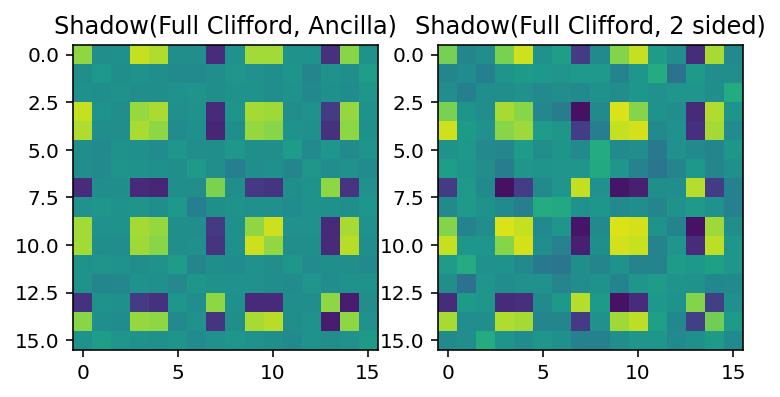

In [22]:


plt.subplot(121)
plt.title("Shadow(Full Clifford, Ancilla)")
plt.imshow(rho_shadow.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)
plt.title("Shadow(Full Clifford, 2 sided)")
plt.imshow(rho_shadow2.real,vmax=0.7,vmin=-0.7)
plt.show()


# Overlap prediction

Now we'll construct a prediction of the overlap 
$$\mathrm{Tr}[\mathcal{E}(\rho_i^{in})\sigma_i] = \mathrm{Tr}[(\rho_i^{in\,T}\otimes \sigma_i(\theta))\Lambda] $$

between the output of the channel $\mathcal{E}(\rho^{in})$ with another density matrix (a pure state) $\sigma$

<div>
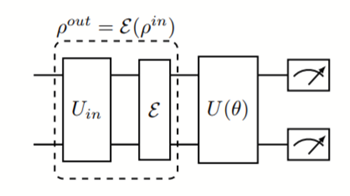
</div>


In [23]:
N = 2
# Channel
qc = qiskit.QuantumCircuit(N)
channel(N,qc)

# test state
sigma = qiskit.QuantumCircuit(N)
sigma.ry(1.23,0)
sigma.ry(2.34,1)

# input to channel to predict
qc_in = qiskit.QuantumCircuit(N)
qc_in.rx(.11,0)
qc_in.rx(.22,1)

rho_in    = qiskit.quantum_info.DensityMatrix(qc_in)
rho_sigma = qiskit.quantum_info.DensityMatrix(sigma)

In [24]:
# Version 1, run the circuit above and measure P(00) state 
qc_all = qc_in.compose(qc)
# now apple inverse(sigmaa)

qc_all.ry(-1.23,0)
qc_all.ry(-2.34,1)
qc_all.draw()

┌──────────┐┌───┐     ┌───────────┐
q_0: ┤ Rx(0.11) ├┤ H ├──■──┤ Ry(-1.23) ├
     ├──────────┤└───┘┌─┴─┐├───────────┤
q_1: ┤ Rx(0.22) ├─────┤ X ├┤ Ry(-2.34) ├
     └──────────┘     └───┘└───────────┘

In [25]:
overlap_full = np.abs(qiskit.quantum_info.Statevector(qc_all)[0])**2

In [26]:
# version 2, evolve via the true choi matrix
overlap_trace = np.trace(np.kron(rho_in.data.T,rho_sigma.data)@choi_actual.data).real

# version 3, qiskit formalism
rho_evolve     = choi_actual._evolve(rho_in)
overlap_evolve = rho_sigma.expectation_value(rho_evolve).real
print(f"trace circuit={overlap_full:0.4f}")
print(f"trace        ={overlap_trace:0.4f}")
print(f"evolution    ={overlap_evolve:0.4f}")

trace circuit=0.3576
trace        =0.3576
evolution    =0.3576


Using our two shadow methods (note, if $\rho^{in}$ and $\sigma$ are Clifford/Pauli circuits, this can be done in a more efficient manner)

In [27]:
shadow_overlap  = np.trace(np.kron(rho_in.data.T,rho_sigma.data)@rho_shadow).real
shadow_overlap2 = np.trace(np.kron(rho_in.data.T,rho_sigma.data)@rho_shadow2).real
print(f"ancilla shadow   ={shadow_overlap:0.4f} (prediction)")
print(f"two sided shadow ={shadow_overlap2:0.4f} (prediction)")

ancilla shadow   =0.3890 (prediction)
two sided shadow =0.2774 (prediction)


small comment on why things are so bad here - the Choi matrix isnt physical! Lets see how

In [28]:
rho_out = qiskit.quantum_info.Choi(rho_shadow2)._evolve(rho_in)
print(f"Tr[rho_out]={rho_out.trace().real:0.4f}")
eigs = np.linalg.eigvalsh(rho_out.data)
print(f"sum of eigenvalues below 0 ={np.sum(eigs[eigs<0]):0.4f}")

Tr[rho_out]=0.9115
sum of eigenvalues below 0 =-0.1490



---

we can project to get rid of some of these problems, and the two sided shadow will see a much nicer gain

In [29]:
def purify(N,lam):
    _,vs = np.linalg.eigh(lam)
    lam_pure = np.outer(vs[:,-1],vs[:,-1].conj().T) * 2**N
    return lam_pure
shadow_overlap_pure  = np.trace(np.kron(rho_in.data.T,rho_sigma.data)@purify(N,rho_shadow)).real
shadow_overlap2_pure = np.trace(np.kron(rho_in.data.T,rho_sigma.data)@purify(N,rho_shadow2)).real
print(f"trace circuit    = {overlap_full:0.4f}")
print(f"ancilla shadow   = {shadow_overlap_pure:0.4f} (prediction)")
print(f"two sided shadow = {shadow_overlap2_pure:0.4f} (prediction)")

trace circuit    = 0.3576
ancilla shadow   = 0.3617 (prediction)
two sided shadow = 0.3376 (prediction)


In [30]:
rho_out = qiskit.quantum_info.Choi(purify(N,rho_shadow2))._evolve(rho_in)
print(f"Tr[rho_out]={rho_out.trace().real:0.4f}")
eigs = np.linalg.eigvalsh(rho_out.data)
print(f"sum of eigenvalues below 0 ={np.sum(eigs[eigs<0]):0.4f}")

Tr[rho_out]=0.9272
sum of eigenvalues below 0 =-0.0000


Purification only takes care of the postive semi-definite requirement ($\mathcal{CP}$). We'll need some other machinary to take care of $\mathcal{TP}$ projection

In [31]:
import scipy.sparse as sps
def partial_trace_super(dim1, dim2):
    """
    From Qiskit internals
    Return the partial trace superoperator in the column-major basis.
    This returns the superoperator S_TrB such that:
        S_TrB * vec(rho_AB) = vec(rho_A)
    for rho_AB = kron(rho_A, rho_B)
    Args:
        dim1: the dimension of the system not being traced
        dim2: the dimension of the system being traced over
    Returns:
        A Numpy array of the partial trace superoperator S_TrB.
    """

    iden = sps.identity(dim1)
    ptr = sps.csr_matrix((dim1 * dim1, dim1 * dim2 * dim1 * dim2))

    for j in range(dim2):
        v_j = sps.coo_matrix(([1], ([0], [j])), shape=(1, dim2))
        tmp = sps.kron(iden, v_j.tocsr())
        ptr += sps.kron(tmp, tmp)

    return ptr
def make_tp(rho, validate=True,
            MtM=None, Mb=None):
    '''
    Projects a 4^N x 4^N choi matrix into the space of TP matrices
    Citation: 10.1103/PhysRevA.98.062336 
    '''
    dim  = rho.shape[0]
    sdim = int(np.sqrt(dim))
    if MtM==None and Mb==None:
        M = partial_trace_super(sdim, sdim) # M*vec[rho] should be identity 
        MdagM = M.conj().T@M
        MdagI = M.conj().T@np.eye(sdim).ravel('F')
    
    # vec[rho] operation
    vec_rho = rho.ravel('F')
    
    new_rho = vec_rho - 1/sdim * MdagM@vec_rho + 1/sdim * MdagI
    new_rho = new_rho.reshape(dim,dim,order='F')
    if validate: 
        if abs(rho.trace().real-new_rho.trace().real) > 1e-4: 
            print(rho.trace(),new_rho.trace())
        assert abs(rho.trace().real-new_rho.trace().real) < 1e-4
    return new_rho


In [32]:
rho_out_tp = qiskit.quantum_info.Choi(make_tp(purify(N,rho_shadow2)))._evolve(rho_in)
print(f"Tr[rho_out]={rho_out_tp.trace().real:0.4f}")
eigs = np.linalg.eigvalsh(rho_out_tp.data)
print(f"sum of eigenvalues below 0 ={np.sum(eigs[eigs<0]):0.4f}")

Tr[rho_out]=1.0000
sum of eigenvalues below 0 =0.0000


In [33]:
print(f"trace circuit    = {overlap_full:0.4f}")
print("---")
print(f"two sided shadow = {shadow_overlap2:0.4f} (prediction)")
print(f"two sided shadow = {shadow_overlap2_pure:0.4f} (prediction purified)")
print(f"two sided shadow = {np.trace(rho_out_tp.data@rho_sigma.data).real:0.4f} (prediction TP(purified))")

trace circuit    = 0.3576
---
two sided shadow = 0.2774 (prediction)
two sided shadow = 0.3376 (prediction purified)
two sided shadow = 0.3558 (prediction TP(purified))


Generally $\mathcal{TP}[\mathcal{CP}(\Lambda^O)] \not =\mathcal{CPTP}[\Lambda^O]$; proper projection into both spaces is left as an open question, as at scale most methods are probably not practical with shadows